In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.dates as mdates

In [5]:
meter_reading = pd.read_csv("../data/meter_reading/cleaned/allmeter_reading_daily.csv")
meter_reading['date'] = pd.to_datetime(meter_reading['date'])
meter_reading.head()

,building_id,meter,date,meter_reading
0,Bear_assembly_Angel,electricity,2016-01-01,12808.1620
1,Bear_assembly_Angel,electricity,2016-01-02,9251.0003
2,Bear_assembly_Angel,electricity,2016-01-03,14071.6500
3,Bear_assembly_Angel,electricity,2016-01-04,12860.3758
4,Bear_assembly_Angel,electricity,2016-01-05,12212.8585


In [34]:
# Buildings data
metadata = pd.read_csv("../data/metadata/metadata.csv")
metadata.info()

# Features from buildings metadata to add to meters dataset
buildings_sel = metadata[["building_id","site_id","primaryspaceusage","timezone"]]
meter_reading = meter_reading.merge(buildings_sel, on="building_id", how = "left")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1636 entries, 0 to 1635
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   building_id            1636 non-null   object 
 1   site_id                1636 non-null   object 
 2   building_id_kaggle     1449 non-null   float64
 3   site_id_kaggle         1599 non-null   float64
 4   primaryspaceusage      1615 non-null   object 
 5   sub_primaryspaceusage  1615 non-null   object 
 6   sqm                    1636 non-null   float64
 7   sqft                   1636 non-null   float64
 8   lat                    1399 non-null   float64
 9   lng                    1399 non-null   float64
 10  timezone               1636 non-null   object 
 11  electricity            1578 non-null   object 
 12  hotwater               185 non-null    object 
 13  chilledwater           555 non-null    object 
 14  steam                  370 non-null    object 
 15  wate

In [35]:
print(meter_reading['meter'].value_counts())

meter
electricity     1153518
chilledwater     405705
steam            270470
hotwater         135235
gas              129387
water            106726
irrigation        27047
solar              3655
Name: count, dtype: int64


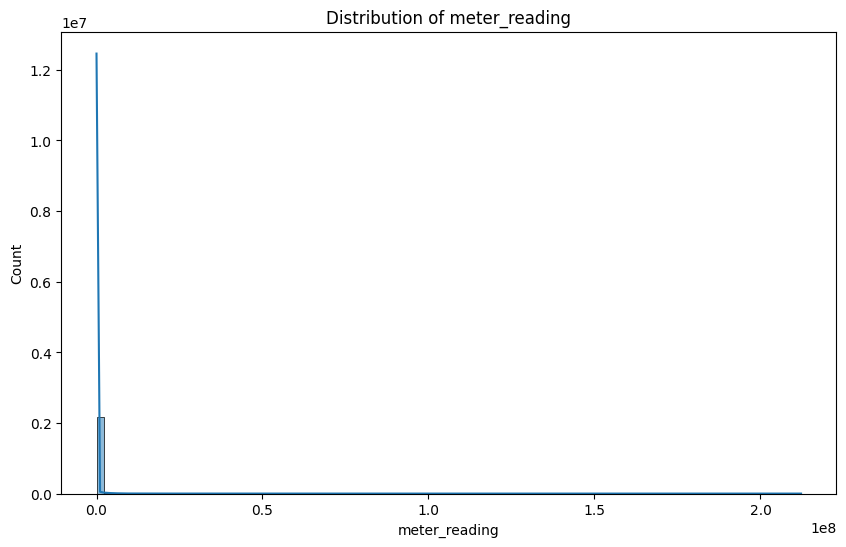

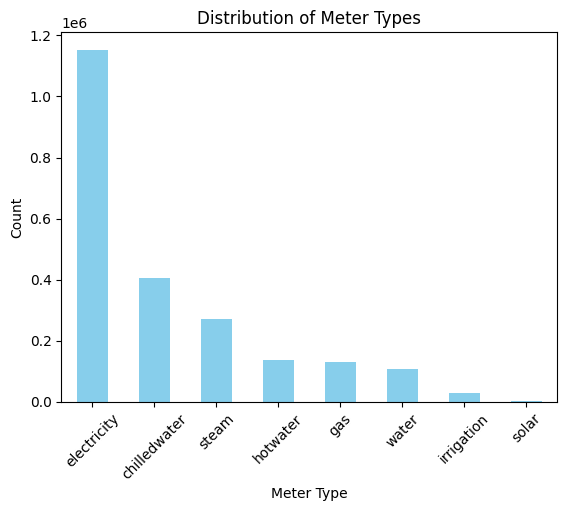

In [36]:
# Distribution of numerical features
for column in ['meter_reading']:
    plt.figure(figsize=(10, 6))
    sns.histplot(meter_reading[column], bins=100, kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()


# Check the meter counts 
meter_counts = meter_reading["meter"].value_counts()

# Plot the results
meter_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Meter Types')
plt.xlabel('Meter Type')
plt.ylabel('Count')
plt.xticks(rotation=45) 
plt.show()


The histogram shows the distribution of meter readings, where the majority of the readings are clustered near zero, indicating a highly skewed distribution. There is an extremely low frequency of readings as the meter reading value increases, which suggests that high meter readings are rare or outliers. The y-axis, representing the count, is quite low across the board, which further emphasizes the concentration of smaller values. 

The most popular meter type is electricity, followed by chilledwater. The least common meter type is solar.

Since the distribution of the meter readings is very heavily right skewed, we can apply a log transformation.

/var/folders/20/6gd3bgbx1kn0xfsyzbfxk8nm0000gn/T/ipykernel_23466/2543942246.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(meter_reading["meter_reading"].dropna()+1))


<Axes: xlabel='meter_reading', ylabel='Density'>

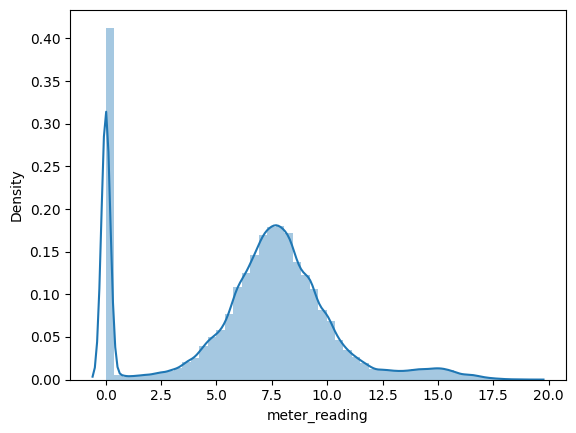

In [37]:
# Log transformation.
sns.distplot(np.log(meter_reading["meter_reading"].dropna()+1))

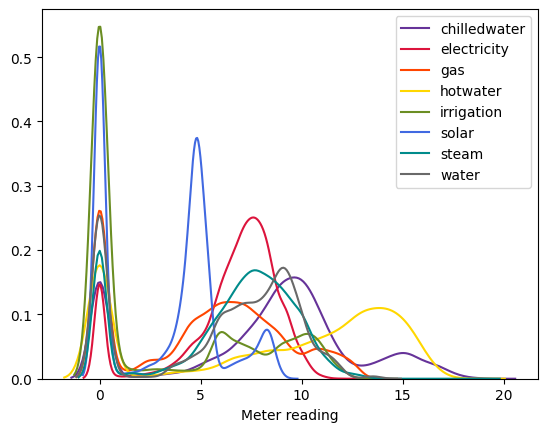

In [38]:
# Distribution by Meter

colors = ["rebeccapurple", "crimson", "orangered", "gold", "olivedrab", "royalblue", "darkcyan", "dimgrey"]

meter_types = ["chilledwater", "electricity", "gas", "hotwater", "irrigation", "solar", "steam", "water"]

f, axes = plt.subplots(1, 1)

for i, meter_type in enumerate(meter_types):
    data = np.log(meter_reading.dropna().loc[meter_reading["meter"] == meter_type, "meter_reading"] + 1)
    sns.kdeplot(data, color=colors[i], label=meter_type, ax=axes, bw_method=0.1)

axes.set(ylabel="", xlabel="Meter reading")
axes.legend()
plt.show()

## Bivaraite Analysis 

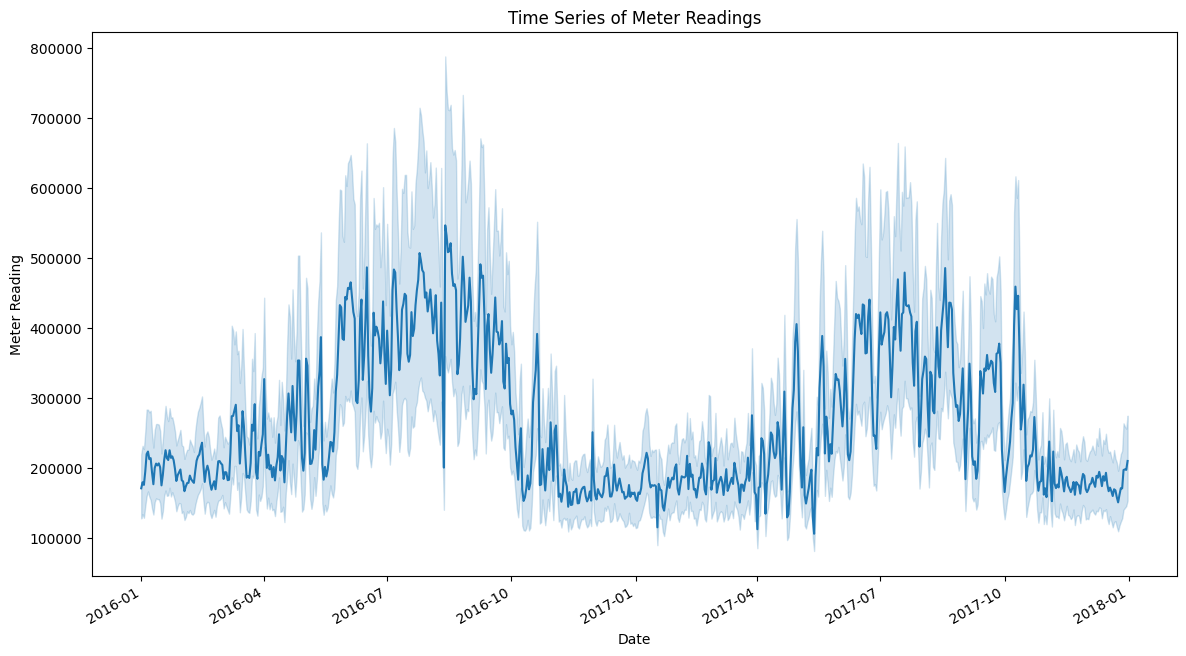

/var/folders/20/6gd3bgbx1kn0xfsyzbfxk8nm0000gn/T/ipykernel_23466/3297033682.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45, ha="right", fontsize=10)  # Adjust fontsize as needed


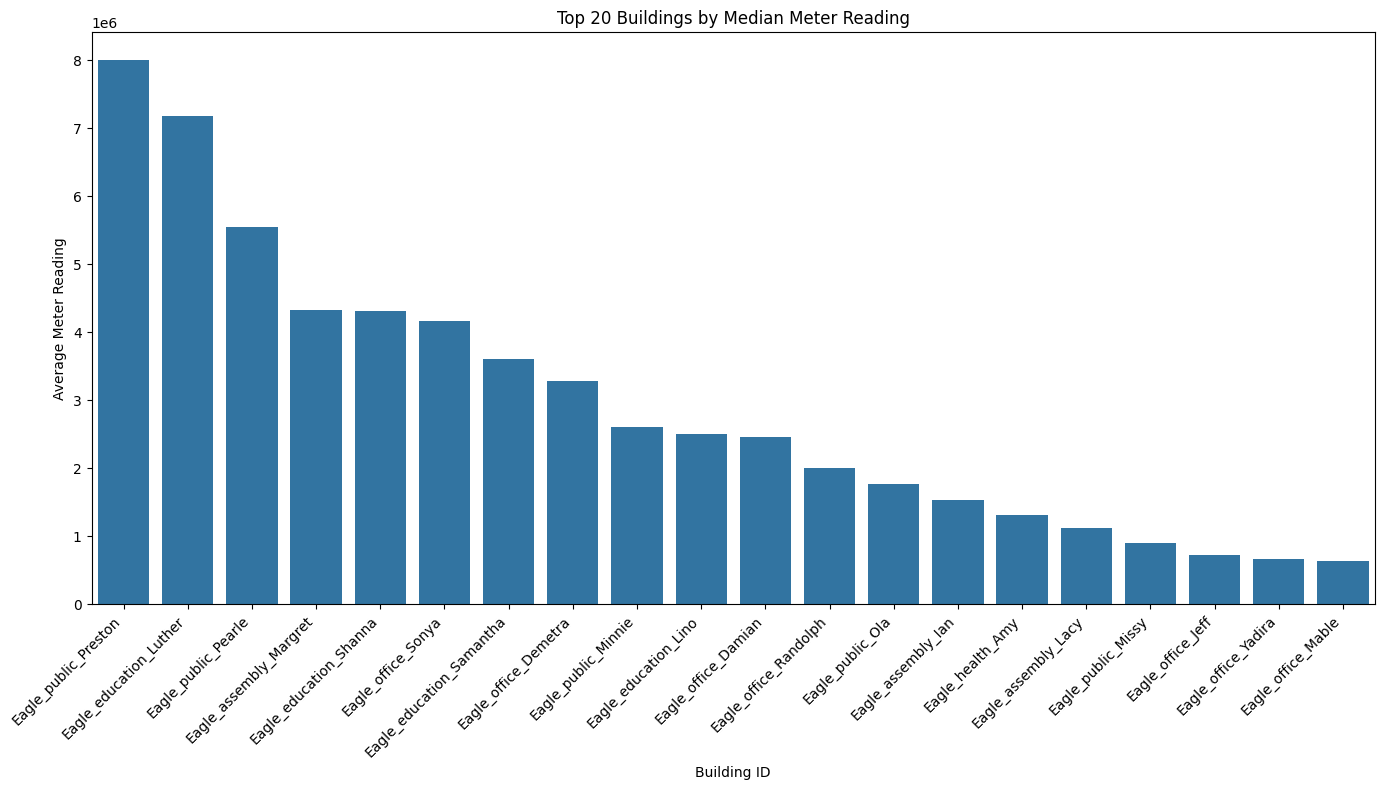

/Users/sameeraboppana/work_env/lib/python3.11/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


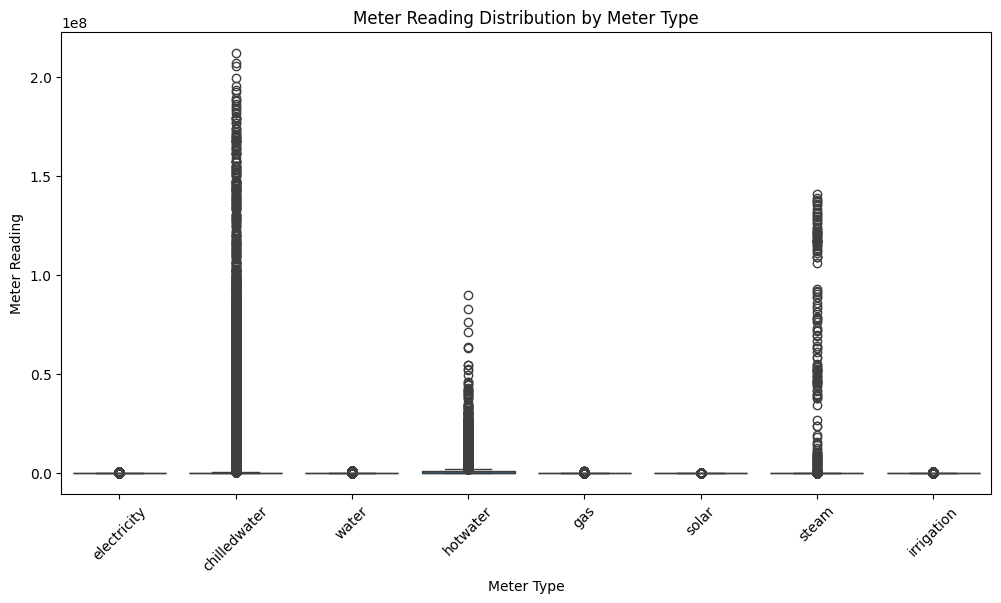

In [39]:
# Time series plot for meter readings over time
plt.figure(figsize=(14, 8))  
sns.lineplot(x='date', y='meter_reading', data=meter_reading)

plt.gcf().autofmt_xdate()  # Auto-format the date labels
plt.title('Time Series of Meter Readings')
plt.xlabel('Date')
plt.ylabel('Meter Reading')

plt.show()


# Average Meter Reading vs. Building ID
# Calculate average meter readings for each building
average_readings_by_building = meter_reading.groupby('building_id')['meter_reading'].median().reset_index()

# Sort the buildings by average meter reading in descending order and select the top 20
top_buildings = average_readings_by_building.sort_values(by='meter_reading', ascending=False).head(20)

# Plotting the average meter readings for the top 20 buildings
plt.figure(figsize=(14, 8))  
barplot = sns.barplot(data=top_buildings, x='building_id', y='meter_reading')
plt.title('Top 20 Buildings by Median Meter Reading')
plt.xlabel('Building ID')
plt.ylabel('Average Meter Reading')

# Rotate the x-axis labels for better readability
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45, ha="right", fontsize=10)  # Adjust fontsize as needed
plt.tight_layout()
plt.show()

# Meter Reading Distribution by Meter Type
# This is relevant if you have different meter types
plt.figure(figsize=(12, 6))
sns.boxplot(data=meter_reading, x='meter', y='meter_reading')
plt.title('Meter Reading Distribution by Meter Type')
plt.xlabel('Meter Type')
plt.ylabel('Meter Reading')
plt.xticks(rotation=45)
plt.show()


The time series graph displays the meter readings over a period from January 2016 to February 2017. The data exhibits significant fluctuations and a few noticeable peaks, suggesting that there may be periodic trends or that certain times have unusually high readings. The confidence interval (shaded area) suggests variability in the readings over time, with some periods having a wider range of readings. The overall trend appears to show some seasonality, as indicated by the repeating patterns of peaks and troughs, which could be associated with operational cycles or seasonal usage patterns of the facility or equipment being measured.

The first building, 'Eagle_education_Peter', has significantly higher average meter readings compared to the others, suggesting it may have higher energy consumption or operational demands. The buildings with the highest energy consumption predominantly belong to the 'Eagle_education' category, suggesting these types of buildings might typically have higher energy requirements, or it could reflect a specific subset of your dataset where these buildings are overrepresented.

This boxplot shows the distribution of meter readings across different types of meter_reading such as 'electricity', 'chilledwater', 'hotwater', etc. The 'electricity' and 'chilledwater' meter types exhibit significant outliers with extremely high readings compared to other types, as indicated by the points above the main body of the boxplot. This suggests variability in usage or potential issues with meter readings such as spikes or data entry errors. Most meter types show a concentration of readings near the lower end of the scale, but 'electricity' and 'chilledwater' have wider distributions, indicating a broader range of consumption values. The 'steam' meter type also shows a higher median compared to others like 'hotwater' and 'water', which might suggest generally higher usage levels or different operational characteristics associated with those meter types.

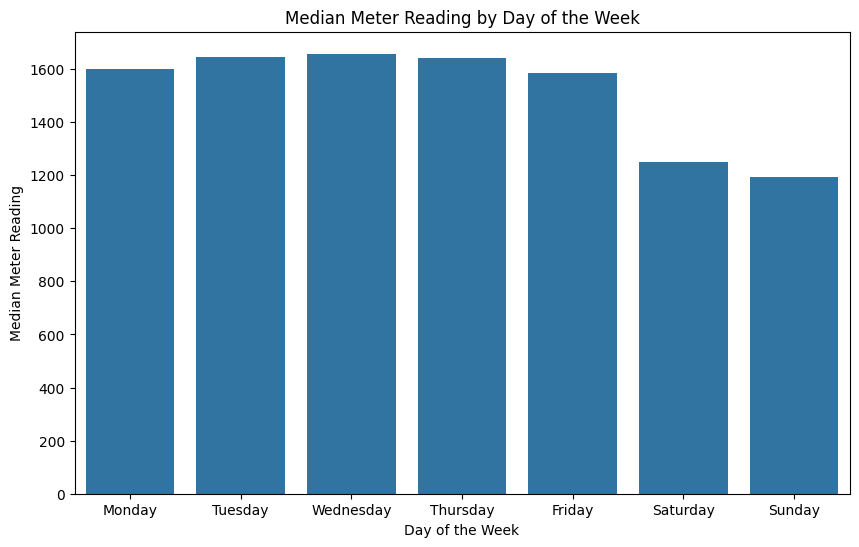

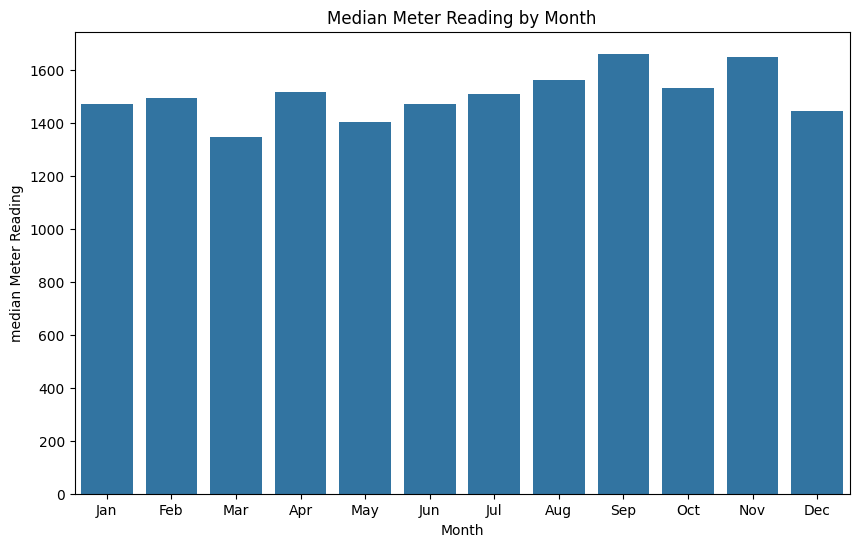

In [40]:
# Extract day of week, month, and hour (if time is available)
meter_reading['day_of_week'] = meter_reading['date'].dt.day_name()
meter_reading['month'] = meter_reading['date'].dt.month

# Aggregate average meter readings by day of the week
avg_by_day = meter_reading.groupby('day_of_week')['meter_reading'].median().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Plot average meter readings by day of the week
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_by_day.index, y=avg_by_day.values)
plt.title('Median Meter Reading by Day of the Week')
plt.ylabel('Median Meter Reading')
plt.xlabel('Day of the Week')
plt.show()

# Aggregate average meter readings by month
avg_by_month = meter_reading.groupby('month')['meter_reading'].median()

# Plot average meter readings by month
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_by_month.index, y=avg_by_month.values)
plt.title('Median Meter Reading by Month')
plt.ylabel('median Meter Reading')
plt.xlabel('Month')
plt.xticks(ticks=range(12), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()


There does not seem to be much variation of meter readings during the week. The weekend seems to have a lower median. 

THere seems to be an increase in energy consumption in the summer months. This can indicate that when it is warmer there is higher energy consumption;

# Combining with Weather

In [48]:
weather = pd.read_csv( "../data/weather/weather.csv")
weather['timestamp'] = pd.to_datetime(weather['timestamp'])

weather


,timestamp,site_id,airTemperature,cloudCoverage,dewTemperature,precipDepth1HR,precipDepth6HR,seaLvlPressure,windDirection,windSpeed
0,2016-01-01 00:00:00,Panther,19.4,NaN,19.4,0.0,NaN,NaN,0.0,0.0
1,2016-01-01 01:00:00,Panther,21.1,6.0,21.1,-1.0,NaN,1019.4,0.0,0.0
2,2016-01-01 02:00:00,Panther,21.1,NaN,21.1,0.0,NaN,1018.8,210.0,1.5
3,2016-01-01 03:00:00,Panther,20.6,NaN,20.0,0.0,NaN,1018.1,0.0,0.0
4,2016-01-01 04:00:00,Panther,21.1,NaN,20.6,0.0,NaN,1019.0,290.0,1.5
...,...,...,...,...,...,...,...,...,...,...
331161,2017-12-31 19:00:00,Mouse,8.5,NaN,4.8,NaN,NaN,992.3,210.0,8.2
331162,2017-12-31 20:00:00,Mouse,8.5,NaN,4.5,NaN,NaN,992.1,210.0,7.2
331163,2017-12-31 21:00:00,Mouse,8.2,NaN,4.0,NaN,NaN,992.1,230.0,10.3
331164,2017-12-31 22:00:00,Mouse,7.5,NaN,4.3,NaN,NaN,993.7,260.0,12.9


In [50]:
meter_reading = pd.merge(meter_reading, weather, how='left', left_on=['date', 'site_id'], right_on=['timestamp', 'site_id'])
meter_reading

,building_id,meter,date,meter_reading,day_of_week,month,site_id,primaryspaceusage,timezone,timestamp_x,...,windSpeed_x,timestamp_y,airTemperature_y,cloudCoverage_y,dewTemperature_y,precipDepth1HR_y,precipDepth6HR_y,seaLvlPressure_y,windDirection_y,windSpeed_y
0,Bear_assembly_Angel,electricity,2016-01-01,12808.1620,Friday,1,Bear,Entertainment/public assembly,US/Pacific,2016-01-01,...,0.0,2016-01-01,4.4,0.0,-2.2,0.0,NaN,1020.9,0.0,0.0
1,Bear_assembly_Angel,electricity,2016-01-02,9251.0003,Saturday,1,Bear,Entertainment/public assembly,US/Pacific,2016-01-02,...,3.6,2016-01-02,6.1,NaN,-1.7,0.0,NaN,1020.4,80.0,3.6
2,Bear_assembly_Angel,electricity,2016-01-03,14071.6500,Sunday,1,Bear,Entertainment/public assembly,US/Pacific,2016-01-03,...,2.6,2016-01-03,7.8,NaN,1.1,0.0,NaN,1014.8,60.0,2.6
3,Bear_assembly_Angel,electricity,2016-01-04,12860.3758,Monday,1,Bear,Entertainment/public assembly,US/Pacific,2016-01-04,...,1.5,2016-01-04,9.4,NaN,5.0,-1.0,NaN,1009.1,110.0,1.5
4,Bear_assembly_Angel,electricity,2016-01-05,12212.8585,Tuesday,1,Bear,Entertainment/public assembly,US/Pacific,2016-01-05,...,6.7,2016-01-05,12.2,NaN,8.9,-1.0,NaN,1004.1,150.0,6.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2231738,Wolf_science_Alfreda,electricity,2017-12-27,1781.3875,Wednesday,12,Wolf,Technology/science,Europe/Dublin,2017-12-27,...,7.0,2017-12-27,0.4,1.0,-1.6,NaN,0.0,992.1,320.0,7.0
2231739,Wolf_science_Alfreda,electricity,2017-12-28,1778.2625,Thursday,12,Wolf,Technology/science,Europe/Dublin,2017-12-28,...,7.0,2017-12-28,-0.3,7.0,-1.0,NaN,0.0,1003.6,270.0,7.0
2231740,Wolf_science_Alfreda,electricity,2017-12-29,1769.8075,Friday,12,Wolf,Technology/science,Europe/Dublin,2017-12-29,...,5.0,2017-12-29,2.8,8.0,1.3,NaN,0.0,998.2,150.0,5.0
2231741,Wolf_science_Alfreda,electricity,2017-12-30,1755.7325,Saturday,12,Wolf,Technology/science,Europe/Dublin,2017-12-30,...,5.0,2017-12-30,0.8,8.0,0.4,NaN,70.0,988.2,110.0,5.0


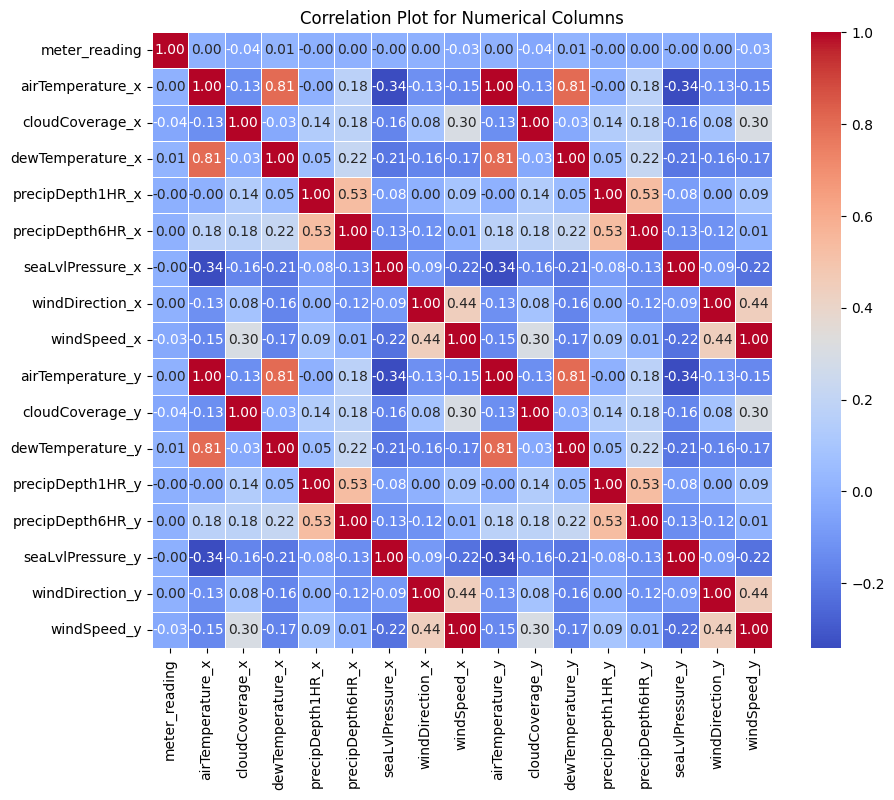

In [59]:
numerical_columns = meter_reading.select_dtypes(include=['float64', 'int64'])

# Calculate correlation matrix
correlation_matrix = numerical_columns.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Plot for Numerical Columns')
plt.show()

The pairs (airTemperature_x, airTemperature_y), (dewTemperature_x, dewTemperature_y), and (windSpeed_x, windSpeed_y) show very high positive correlations (0.81 or higher), suggesting that these measurements are very similar between the two sets represented by "_x" and "_y" suffixes, which could represent similar conditions or measurements taken at different times or situations.

The meter_reading variable has very low correlation with most other variables, often close to 0, indicating it does not share a strong linear relationship with these weather or environmental measurements.

Some variables like seaLvPressure_x and seaLvPressure_y also have a perfect correlation of 1.00, suggesting they are identical or measure the same phenomenon in different instances or settings.

Negative correlations are visible but not very strong in this dataset; for example, seaLvPressure_x and airTemperature_x have a correlation of -0.34, indicating a moderate inverse relationship between sea level pressure and air temperature in the "_x" setting.